In [ ]:
!git clone https://github.com/Ruben-Boeckx/Experimental-Analysis-of-GNNs-for-CCF.git

Cloning into 'Experimental-Analysis-of-GNNs-for-CCF'...
remote: Enumerating objects: 380, done.
remote: Counting objects: 100% (143/143), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 380 (delta 86), reused 100 (delta 43), pack-reused 237
Receiving objects: 100% (380/380), 535.88 KiB | 3.83 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [ ]:
%cd /content/Experimental-Analysis-of-GNNs-for-CCF
!git pull

/content/Experimental-Analysis-of-GNNs-for-CCF
Already up to date.


In [ ]:
import torch
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git
!pip install category_encoders rarfile

Found existing installation: torch-scatter 2.1.2
Uninstalling torch-scatter-2.1.2:
  Successfully uninstalled torch-scatter-2.1.2
Found existing installation: torch-sparse 0.6.18
Uninstalling torch-sparse-0.6.18:
  Successfully uninstalled torch-sparse-0.6.18
Found existing installation: torch-cluster 1.6.3
Uninstalling torch-cluster-1.6.3:
  Successfully uninstalled torch-cluster-1.6.3
Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
  Using cached torch_scatter-2.1.2-cp310-cp310-linux_x86_64.whl
Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
  Using cached torch_sparse-0.6.18-cp310-cp310-linux_x86_64.whl
Looking in links: https://data.pyg.org/whl/torch-2.3.1+cu121.html
  Using cached torch_cluster-1.6.3-cp310-cp310-linux_x86_64.whl
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-6j64an7s
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-6j64a

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/A-Benchmark-of-Network-Learning-Techniques

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/A-Benchmark-of-Network-Learning-Techniques


In [ ]:
import numpy as np
import pandas as pd
import torch
from Graph.graph_construction import GraphConstruction
from Models.GNNs import GraphSAGE
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torch_geometric.nn import to_hetero
from torch_geometric.loader import HGTLoader
from sklearn.metrics import average_precision_score, precision_score, recall_score, f1_score, roc_auc_score
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
file_id = '127LcoK858671J38JlmWOyATZEXZR4CyA'
rar_file_name = 'final_dataset.rar'
download_path = '/content/A-Benchmark-of-Network-Learning-Techniques/' + rar_file_name

!gdown https://drive.google.com/uc?id={file_id} -O {download_path}

import os
print(f"File exists: {os.path.exists(download_path)}")

!ls -l /content/A-Benchmark-of-Network-Learning-Techniques/

!file {download_path}

!unrar x -Y "{download_path}" "/content/Dataset/"


Downloading...
From: https://drive.google.com/uc?id=127LcoK858671J38JlmWOyATZEXZR4CyA
To: /content/A-Benchmark-of-Network-Learning-Techniques/final_dataset.rar
100% 23.3M/23.3M [00:00<00:00, 71.5MB/s]
File exists: True
total 23072
drwxr-xr-x 6 root root     4096 Jul 18 14:40 A-Benchmark-of-Network-Learning-Techniques
-rw-r--r-- 1 root root    52419 Jul 18 08:19 Bipartite_graph.ipynb
-rw-r--r-- 1 root root    62167 Jul 18 08:19 Example.ipynb
-rw-r--r-- 1 root root 23304861 Jul 18 14:43 final_dataset.rar
drwxr-xr-x 3 root root     4096 Jul 18 08:19 Graph
drwxr-xr-x 3 root root     4096 Jul 18 08:19 Models
-rw-r--r-- 1 root root   120023 Jul 18 08:19 Other_ML_techniques.ipynb
drwxr-xr-x 3 root root     4096 Jul 18 08:19 Preprocessing
-rw-r--r-- 1 root root      160 Jul 18 08:19 README.md
-rw-r--r-- 1 root root    55799 Jul 18 08:19 visualization.ipynb
/content/A-Benchmark-of-Network-Learning-Techniques/final_dataset.rar: RAR archive data, v5

UNRAR 6.11 beta 1 freeware      Copyright (c) 

In [ ]:
dataset = pd.read_csv('/content/Dataset/final_dataset.csv')

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [ ]:
graph_constructor = GraphConstruction(dataset)
data = graph_constructor.apply_graph_construction()

Fraud Percentage in Train Mask: 50.00%
Fraud Percentage in Test Mask: 0.61%
Fraud Percentage in Val Mask: 0.63%
Graph Construction Successful!


In [ ]:
model = GraphSAGE(hidden_dim=64, embedding_dim=64, output_dim=1, num_layers=3, dropout_rate=0.5, sage_aggr='mean')
model = to_hetero(model, data.metadata(), aggr='sum')
data, model = data.to(device), model.to(device)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
criterion = torch.nn.BCEWithLogitsLoss()

/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch_geometric/nn/to_hetero_transformer.py:165: UserWarning: The type 'rev_received by' contains invalid characters which may lead to unexpected behavior. To avoid any issues, ensure that your types only contain letters, numbers and underscores.
  warnings.warn(


In [ ]:
kwargs = {'batch_size': 2048, 'num_workers': 2, 'persistent_workers': True}

train_loader = HGTLoader(
    data, num_samples={key: [2048] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].train_mask), **kwargs)

test_loader = HGTLoader(
    data, num_samples={key: [2048] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].test_mask), **kwargs)

val_loader = HGTLoader(
    data, num_samples={key: [2048] for key in data.node_types},
    input_nodes=('transaction', data['transaction'].val_mask), **kwargs)

In [ ]:
@torch.no_grad()
def init_params():
    batch = next(iter(train_loader))
    batch = batch.to(device, 'edge_index')
    model(batch.x_dict, batch.edge_index_dict)

In [ ]:
def train():
    model.train()
    total_examples = total_loss = 0

    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        batch = batch.to(device, 'edge_index')
        batch_size = batch['transaction'].batch_size
        out = model(batch.x_dict, batch.edge_index_dict)['transaction'][:batch_size]
        loss = criterion(out.squeeze(1), batch['transaction'].y[:batch_size].float())
        loss.backward()
        optimizer.step()

        total_examples += batch_size
        total_loss += float(loss) * batch_size

    scheduler.step()
    return total_loss / total_examples

In [ ]:
@torch.no_grad()
def test(loader):
    model.eval()
    y_pred_probas = []
    y_trues = []
    total_examples = total_loss = 0

    for batch in tqdm(loader):
        batch = batch.to(device, 'edge_index')
        batch_size = batch['transaction'].batch_size
        y = batch['transaction'].y[:batch_size]
        y_hat = model(batch.x_dict, batch.edge_index_dict)['transaction'][:batch_size]
        loss = criterion(y_hat.squeeze(1), y.float())

        total_examples += batch_size
        total_loss += float(loss) * batch_size
        y_pred_probas.append(torch.sigmoid(y_hat.cpu()).numpy())
        y_trues.append(y.cpu().numpy())

    y_true = np.concatenate(y_trues)
    y_pred_proba = np.concatenate(y_pred_probas)

    return y_true, y_pred_proba, total_loss / total_examples

In [ ]:
init_params()

training_losses = []
validation_losses = []

consecutive_increases = 0
max_consecutive_increases = 5

for epoch in range(50):
    loss = train()
    print(f'Epoch {epoch+1:02d}, Training loss: {loss:.4f}')
    training_losses.append(loss)

    y_val, y_val_pred_proba, val_loss = test(val_loader)
    print(f'Epoch {epoch+1:02d}, Validation loss: {val_loss:.4f}')
    validation_losses.append(val_loss)

    ap_val = average_precision_score(y_val, y_val_pred_proba)
    roc_val = roc_auc_score(y_val, y_val_pred_proba)

    print(f'Epoch {epoch+1:02d}, Average precision validation set: {ap_val:.2f}, ROC AUC validation set: {roc_val:.2f}')

    # Check for early stopping
    if epoch > 0 and val_loss >= validation_losses[-2]:
        consecutive_increases += 1
        if consecutive_increases >= max_consecutive_increases:
            print(f'Early stopping triggered at epoch {epoch+1}')
            break
    else:
        consecutive_increases = 0

100%|██████████| 466/466 [01:30<00:00,  5.13it/s]


Epoch 01, Training loss: 0.4364


100%|██████████| 49/49 [00:04<00:00, 10.29it/s]


Epoch 01, Validation loss: 0.2164
Epoch 01, Average precision validation set: 0.46, ROC AUC validation set: 0.97


100%|██████████| 466/466 [01:21<00:00,  5.74it/s]


Epoch 02, Training loss: 0.2495


100%|██████████| 49/49 [00:04<00:00, 10.70it/s]


Epoch 02, Validation loss: 0.1559
Epoch 02, Average precision validation set: 0.66, ROC AUC validation set: 0.98


100%|██████████| 466/466 [01:25<00:00,  5.42it/s]


Epoch 03, Training loss: 0.1965


100%|██████████| 49/49 [00:04<00:00,  9.90it/s]


Epoch 03, Validation loss: 0.1441
Epoch 03, Average precision validation set: 0.75, ROC AUC validation set: 0.98


100%|██████████| 466/466 [01:29<00:00,  5.18it/s]


Epoch 04, Training loss: 0.1751


100%|██████████| 49/49 [00:03<00:00, 14.04it/s]


Epoch 04, Validation loss: 0.1151
Epoch 04, Average precision validation set: 0.78, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:34<00:00,  4.92it/s]


Epoch 05, Training loss: 0.1636


100%|██████████| 49/49 [00:04<00:00, 10.33it/s]


Epoch 05, Validation loss: 0.1170
Epoch 05, Average precision validation set: 0.78, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:34<00:00,  4.94it/s]


Epoch 06, Training loss: 0.1553


100%|██████████| 49/49 [00:05<00:00,  9.22it/s]


Epoch 06, Validation loss: 0.1055
Epoch 06, Average precision validation set: 0.79, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.12it/s]


Epoch 07, Training loss: 0.1490


100%|██████████| 49/49 [00:04<00:00, 10.19it/s]


Epoch 07, Validation loss: 0.1083
Epoch 07, Average precision validation set: 0.80, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:36<00:00,  4.84it/s]


Epoch 08, Training loss: 0.1444


100%|██████████| 49/49 [00:05<00:00,  9.59it/s]


Epoch 08, Validation loss: 0.1119
Epoch 08, Average precision validation set: 0.79, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:34<00:00,  4.95it/s]


Epoch 09, Training loss: 0.1414


100%|██████████| 49/49 [00:04<00:00,  9.91it/s]


Epoch 09, Validation loss: 0.0970
Epoch 09, Average precision validation set: 0.80, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.17it/s]


Epoch 10, Training loss: 0.1378


100%|██████████| 49/49 [00:02<00:00, 18.32it/s]


Epoch 10, Validation loss: 0.0945
Epoch 10, Average precision validation set: 0.80, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:40<00:00,  4.64it/s]


Epoch 11, Training loss: 0.1305


100%|██████████| 49/49 [00:05<00:00,  9.03it/s]


Epoch 11, Validation loss: 0.1013
Epoch 11, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:29<00:00,  5.19it/s]


Epoch 12, Training loss: 0.1292


100%|██████████| 49/49 [00:03<00:00, 12.74it/s]


Epoch 12, Validation loss: 0.1019
Epoch 12, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.16it/s]


Epoch 13, Training loss: 0.1281


100%|██████████| 49/49 [00:04<00:00, 10.29it/s]


Epoch 13, Validation loss: 0.0999
Epoch 13, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:37<00:00,  4.79it/s]


Epoch 14, Training loss: 0.1273


100%|██████████| 49/49 [00:04<00:00, 11.02it/s]


Epoch 14, Validation loss: 0.0988
Epoch 14, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.16it/s]


Epoch 15, Training loss: 0.1262


100%|██████████| 49/49 [00:03<00:00, 12.65it/s]


Epoch 15, Validation loss: 0.1002
Epoch 15, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:38<00:00,  4.73it/s]


Epoch 16, Training loss: 0.1267


100%|██████████| 49/49 [00:05<00:00,  9.74it/s]


Epoch 16, Validation loss: 0.1011
Epoch 16, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.14it/s]


Epoch 17, Training loss: 0.1257


100%|██████████| 49/49 [00:05<00:00,  9.71it/s]


Epoch 17, Validation loss: 0.1015
Epoch 17, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.15it/s]


Epoch 18, Training loss: 0.1259


100%|██████████| 49/49 [00:03<00:00, 12.57it/s]


Epoch 18, Validation loss: 0.1040
Epoch 18, Average precision validation set: 0.81, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:40<00:00,  4.62it/s]


Epoch 19, Training loss: 0.1248


100%|██████████| 49/49 [00:03<00:00, 13.44it/s]


Epoch 19, Validation loss: 0.0981
Epoch 19, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.17it/s]


Epoch 20, Training loss: 0.1244


100%|██████████| 49/49 [00:05<00:00,  9.20it/s]


Epoch 20, Validation loss: 0.0954
Epoch 20, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:36<00:00,  4.82it/s]


Epoch 21, Training loss: 0.1236


100%|██████████| 49/49 [00:02<00:00, 18.27it/s]


Epoch 21, Validation loss: 0.0963
Epoch 21, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:33<00:00,  4.99it/s]


Epoch 22, Training loss: 0.1238


100%|██████████| 49/49 [00:03<00:00, 13.85it/s]


Epoch 22, Validation loss: 0.0956
Epoch 22, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:31<00:00,  5.10it/s]


Epoch 23, Training loss: 0.1237


100%|██████████| 49/49 [00:04<00:00, 11.04it/s]


Epoch 23, Validation loss: 0.0971
Epoch 23, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:41<00:00,  4.58it/s]


Epoch 24, Training loss: 0.1230


100%|██████████| 49/49 [00:02<00:00, 17.29it/s]


Epoch 24, Validation loss: 0.0960
Epoch 24, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:28<00:00,  5.26it/s]


Epoch 25, Training loss: 0.1240


100%|██████████| 49/49 [00:02<00:00, 17.01it/s]


Epoch 25, Validation loss: 0.0960
Epoch 25, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:38<00:00,  4.75it/s]


Epoch 26, Training loss: 0.1235


100%|██████████| 49/49 [00:05<00:00,  9.17it/s]


Epoch 26, Validation loss: 0.0961
Epoch 26, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:33<00:00,  4.98it/s]


Epoch 27, Training loss: 0.1234


100%|██████████| 49/49 [00:04<00:00, 11.65it/s]


Epoch 27, Validation loss: 0.0954
Epoch 27, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:29<00:00,  5.21it/s]


Epoch 28, Training loss: 0.1238


100%|██████████| 49/49 [00:02<00:00, 17.73it/s]


Epoch 28, Validation loss: 0.0964
Epoch 28, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:42<00:00,  4.54it/s]


Epoch 29, Training loss: 0.1229


100%|██████████| 49/49 [00:02<00:00, 17.97it/s]


Epoch 29, Validation loss: 0.0960
Epoch 29, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:29<00:00,  5.21it/s]


Epoch 30, Training loss: 0.1233


100%|██████████| 49/49 [00:03<00:00, 12.41it/s]


Epoch 30, Validation loss: 0.0956
Epoch 30, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:33<00:00,  5.00it/s]


Epoch 31, Training loss: 0.1231


100%|██████████| 49/49 [00:05<00:00,  9.19it/s]


Epoch 31, Validation loss: 0.0961
Epoch 31, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:44<00:00,  4.46it/s]


Epoch 32, Training loss: 0.1231


100%|██████████| 49/49 [00:02<00:00, 18.05it/s]


Epoch 32, Validation loss: 0.0958
Epoch 32, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:31<00:00,  5.10it/s]


Epoch 33, Training loss: 0.1232


100%|██████████| 49/49 [00:04<00:00,  9.94it/s]


Epoch 33, Validation loss: 0.0966
Epoch 33, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:41<00:00,  4.58it/s]


Epoch 34, Training loss: 0.1234


100%|██████████| 49/49 [00:03<00:00, 16.17it/s]


Epoch 34, Validation loss: 0.0964
Epoch 34, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:29<00:00,  5.20it/s]


Epoch 35, Training loss: 0.1221


100%|██████████| 49/49 [00:02<00:00, 18.18it/s]


Epoch 35, Validation loss: 0.0960
Epoch 35, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:29<00:00,  5.21it/s]


Epoch 36, Training loss: 0.1232


100%|██████████| 49/49 [00:05<00:00,  8.87it/s]


Epoch 36, Validation loss: 0.0963
Epoch 36, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:39<00:00,  4.69it/s]


Epoch 37, Training loss: 0.1231


100%|██████████| 49/49 [00:03<00:00, 13.98it/s]


Epoch 37, Validation loss: 0.0963
Epoch 37, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:27<00:00,  5.32it/s]


Epoch 38, Training loss: 0.1229


100%|██████████| 49/49 [00:02<00:00, 18.13it/s]


Epoch 38, Validation loss: 0.0961
Epoch 38, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:42<00:00,  4.54it/s]


Epoch 39, Training loss: 0.1232


100%|██████████| 49/49 [00:02<00:00, 17.45it/s]


Epoch 39, Validation loss: 0.0961
Epoch 39, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:32<00:00,  5.02it/s]


Epoch 40, Training loss: 0.1231


100%|██████████| 49/49 [00:02<00:00, 17.21it/s]


Epoch 40, Validation loss: 0.0966
Epoch 40, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:31<00:00,  5.12it/s]


Epoch 41, Training loss: 0.1235


100%|██████████| 49/49 [00:04<00:00, 10.13it/s]


Epoch 41, Validation loss: 0.0965
Epoch 41, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:40<00:00,  4.66it/s]


Epoch 42, Training loss: 0.1234


100%|██████████| 49/49 [00:03<00:00, 13.36it/s]


Epoch 42, Validation loss: 0.0963
Epoch 42, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:29<00:00,  5.19it/s]


Epoch 43, Training loss: 0.1229


100%|██████████| 49/49 [00:02<00:00, 16.43it/s]


Epoch 43, Validation loss: 0.0966
Epoch 43, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:37<00:00,  4.77it/s]


Epoch 44, Training loss: 0.1232


100%|██████████| 49/49 [00:05<00:00,  8.84it/s]


Epoch 44, Validation loss: 0.0963
Epoch 44, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:36<00:00,  4.81it/s]


Epoch 45, Training loss: 0.1229


100%|██████████| 49/49 [00:03<00:00, 15.84it/s]


Epoch 45, Validation loss: 0.0960
Epoch 45, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:30<00:00,  5.16it/s]


Epoch 46, Training loss: 0.1235


100%|██████████| 49/49 [00:02<00:00, 16.97it/s]


Epoch 46, Validation loss: 0.0961
Epoch 46, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:43<00:00,  4.52it/s]


Epoch 47, Training loss: 0.1231


100%|██████████| 49/49 [00:04<00:00, 10.62it/s]


Epoch 47, Validation loss: 0.0963
Epoch 47, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:31<00:00,  5.11it/s]


Epoch 48, Training loss: 0.1231


100%|██████████| 49/49 [00:02<00:00, 17.99it/s]


Epoch 48, Validation loss: 0.0961
Epoch 48, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:32<00:00,  5.01it/s]


Epoch 49, Training loss: 0.1226


100%|██████████| 49/49 [00:03<00:00, 16.27it/s]


Epoch 49, Validation loss: 0.0968
Epoch 49, Average precision validation set: 0.82, ROC AUC validation set: 0.99


100%|██████████| 466/466 [01:39<00:00,  4.70it/s]


Epoch 50, Training loss: 0.1232


100%|██████████| 49/49 [00:04<00:00,  9.80it/s]


Epoch 50, Validation loss: 0.0961
Epoch 50, Average precision validation set: 0.82, ROC AUC validation set: 0.99


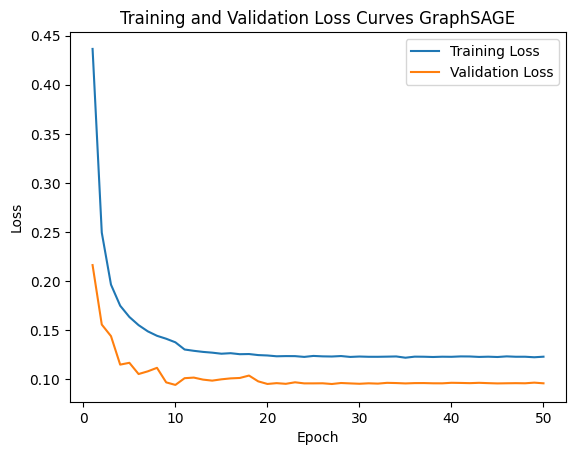

In [ ]:
plt.figure()
plt.plot(range(1, len(training_losses)+1), training_losses, label='Training Loss')
plt.plot(range(1, len(validation_losses)+1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves GraphSAGE')
plt.legend()
plt.show()

In [ ]:
y_test, y_test_pred_proba, test_loss = test(test_loader)
ap_test = average_precision_score(y_test, y_test_pred_proba)
roc_test = roc_auc_score(y_test, y_test_pred_proba)

print(f'Average precision testing set: {ap_test:.4f}, ROC AUC testing set: {roc_test:.4f}')

100%|██████████| 49/49 [00:06<00:00,  8.16it/s]


Average precision testing set: 0.8263, ROC AUC testing set: 0.9904
